In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats, integrate
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
# from copulae import *
from toolbox import *
from KDEs import *
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)


u_arr = ecdf_brr(data.return_brr)
v_arr = ecdf_btc(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

In [29]:
class Copula(object):
    def __init__(self):
        return
    
    def H(self, w, h, r_h): # a helper function to compute the input to F_RF
        A = self.Law_RS.ppf(w) - r_h
        if h!=0:
            B = h
        else:
            B = 0.00001
        return A/B
    
    def g(self, w, h, r_h):
        return self.Law_RF.cdf(self.H(w=w, h=h, r_h=r_h))
    
    def F_RH(self, h, r_h):
        func = partial(self.D1C, h=h, r_h=r_h)
        I = integrate.quad(func, 0.0001, 0.999)
        return 1 - I[0]
    
    def f_RH(self, h, r_h):
        part1 = lambda u: self.c(u, self.g(w=u, h=h, r_h=r_h))
        part2 = lambda u: self.Law_RF.pdf(self.H(w=u, h=h, r_h=r_h))
        integrand = lambda u: part1(u)*part2(u)
        return integrate.quad(integrand, 0.0001, 0.999)[0]/np.abs(h)
        
    
    def _lambda(self, q):
        if q<= 0.5:
            return self.C(q,q)/q
        else:
            return (1-(2*q)+self.C(q,q) )/(1-q)
    
class Gaussian(Copula):
    def __init__(self, rho, Law_RS, Law_RF):
        self.rho = rho         # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        self.meta_Gaussian = stats.multivariate_normal([0,0], # Mean
                                                       [[1,rho], # COV
                                                        [rho,1]])
        
    def C(self, u, v): # Copula Function
        return self.meta_Gaussian.cdf([norm.ppf(u), norm.ppf(v)])
    
    def c(self, u, v): # copula density
        part1 = self.meta_Gaussian.pdf([norm.ppf(u), norm.ppf(v)])
        part2 = norm.pdf(norm.ppf(u))* norm.pdf(norm.ppf(v))
        return part1/part2
    
    def D1C(self, w, h, r_h):
        integrand = lambda u: self.meta_Gaussian.pdf([norm.ppf(w), u]) 
        part2 = 1/norm.pdf(norm.ppf(w))
        return integrate.quad(integrand, -np.infty, norm.ppf(self.g(w, h, r_h)))[0] * part2
    
    def l_fn(self, rho, u, v):
        _meta_Gaussian = stats.multivariate_normal([0,0], 
                                                  [[1,rho], 
                                                   [rho,1]])
        
        z1 = norm.ppf(u)
        z2 = norm.ppf(v)
        
        part1 = []
        for i in range(len(z1)):
            part1.append(_meta_Gaussian.pdf([z1[i], z2[i]]))
        
        part1 = np.array(part1)
        part2 = norm.pdf(norm.ppf(u))*norm.pdf(norm.ppf(v))
        return np.nanmean(np.log(part1/part2))
    
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda rho: -self.l_fn(rho, u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=self.rho,
                             xtol=1e-10, 
                             maxiter=5000,
                             maxfun=400)
        self.rho = result[0]
        self.samples = self.sample(200000) # generate samples for later use
        self.rs = self.samples[:,0]
        self.rf = self.samples[:,1]
        return result
    
    def sample(self, n):
        copula_samples = self.meta_Gaussian.rvs(n)
        samples = np.zeros((n,2))
        samples[:,0]=self.Law_RS.ppf(norm.cdf(copula_samples[:,0]))
        samples[:,1]=self.Law_RF.ppf(norm.cdf(copula_samples[:,1]))
        return samples
    
    def sample_uv(self, n): # sample only the copula (Assuming uniform distribution of marginals)
        copula_samples = self.meta_Gaussian.rvs(n)
        samples = np.zeros((n,2))
        samples[:,0]= norm.cdf(copula_samples[:,0])
        samples[:,1]= norm.cdf(copula_samples[:,1])
        return samples
    
    def tau(self):
        return 2/np.pi * np.arcsin(self.rho)
    
class t_Copula(Copula):
    def __init__(self, rho, nu, Law_RS, Law_RF):
        self.rho        = rho      # Dependence Parameter
        self.nu         = nu       # Degree of Freedom 
        self.Law_RS     = Law_RS   # Marginal Distribution of Spot
        self.Law_RF     = Law_RF   # Marginal Distribution of Future
        self.meta_t     = multivariate_t(nu =nu,  # DF
                                         Sigma=np.array([[1,rho], # COV
                                            [rho,1]]))
        self.t1 = stats.t(df=nu) # inner
        self.t2 = stats.t(df=nu) 
        
    def C(self, u, v): # Copula Function
        return self.meta_t.cdf([self.t1.ppf(u), self.t2.ppf(v)])
    
    def c(self, u, v): # copula density
        part1 = self.meta_t.pdf(self.t1.ppf(u), self.t2.ppf(v))
        part2 = self.t1.pdf(self.t1.ppf(u))* self.t2.pdf(self.t2.ppf(v))
        return part1/part2
    
    def D1C(self, w, h, r_h): # D1Operator
        integrand = lambda u: self.meta_t.pdf(self.t1.ppf(w), u) 
        part2 = 1/self.t1.pdf(self.t1.ppf(w))
        return integrate.quad(integrand, -np.infty, self.t2.ppf(self.g(w, h, r_h)))[0] * part2
    
    def l_fn(self, rho, nu,  u, v, nu_lowerbound=2): # Likelihood Function
        if (np.abs(rho)>=1) or (nu <nu_lowerbound):
            return -5000
        
        _meta_t = multivariate_t(nu=nu,  # DF
                                     Sigma=np.array([[1,rho], # COV
                                                     [rho,1]]))
        
        _t1 = stats.t(df=nu)
        _t2 = stats.t(df=nu)
        
        z1 = _t1.ppf(u) # inner
        z2 = _t2.ppf(v)
        
        part1 = []
        for i in range(len(z1)):
            part1.append(_meta_t.pdf(z1[i], z2[i]))
        
        part1 = np.array(part1)
        part2 = _t1.pdf(_t1.ppf(u))*_t2.pdf(_t2.ppf(v))
        return np.nanmean(np.log(part1/part2))
    
    def canonical_calibrate(self, u, v, nu_lowerbound=2):
        fn_toopt = lambda theta: -self.l_fn(theta[0],theta[1] , u, v, nu_lowerbound)
        result = scipy.optimize.fmin(fn_toopt, x0=(self.rho,self.nu), 
                             xtol=1e-10, 
                             maxiter=5000,
                             maxfun=400)
        self.rho = result[0]
        self.nu  = result[1]
        return result

class Clayton(Copula):
    def __init__(self, theta, Law_RS, Law_RF):
        self.theta = theta     # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        
    def phi(self, t):
        A = 1/self.theta
        B = t**(-self.theta)-1
        return A*B
    
    def phi_inverse(self, t):
        A = (1+self.theta*t)
        B = -1/self.theta
        return A**B
    
    def d_phi(self, t):
        return -t**(-self.theta-1)
    
    def d_phi_inverse(self, t):
        A = 1+ self.theta*t
        B = (-1/self.theta) - 1
        return -1*A**B
    
    def C(self, u, v):
        return self.phi_inverse(self.phi(u)+self.phi(v))
    
    def c(self, u, v): # copula density
        part1 = (1+self.theta) * (u*v)**(-1-self.theta)
        part2 = (-1 + u**(-self.theta) + v**(-self.theta))**(-2-(1/self.theta))
        return part1*part2
    
    def D1C(self, w, h, r_h):
        a = self.phi(w) + self.phi(self.g(w,h,r_h))
        A = self.d_phi_inverse(a)
        B = self.d_phi(w)
        return A*B
    
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda theta: -self.l_fn(theta, u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=self.theta, 
                             xtol=1e-10, 
                             maxiter=5000,
                             maxfun=400)
        self.theta = result[0]
        return result
    
    def l_fn(self, theta, u, v): # log dependency likelihood 
        part1 = (1+theta) * (u*v)**(-1-theta)
        part2 = (-1 + u**(-theta) + v**(-theta))**(-2-(1/theta))
        return np.mean(np.log(part1*part2))
    
    def sample(self, n):
        u1 = stats.uniform().rvs(n)
        v2 = stats.uniform().rvs(n)
        u2 = (u1**(-self.theta)*(v2**(-self.theta/(1+self.theta))-1)+1)**(-1/self.theta)
        samples = np.zeros((n,2))
        samples[:,0]=self.Law_RS.ppf(u1)
        samples[:,1]=self.Law_RF.ppf(u2)
        return samples
    
    
class Frank(Copula):
    def __init__(self, theta, Law_RS, Law_RF):
        self.theta = theta     # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        
    def phi(self, t):
        A = np.exp(-self.theta * t) - 1
        B = np.exp(-self.theta)     - 1
        return -np.log(A/B)
    
    def phi_inverse(self, t):
        A = -1/self.theta
        B = 1 + (np.exp(-t)*(np.exp(-self.theta)-1))
        return A*np.log(B)
    
    def d_phi(self, t):
        A = self.theta * np.exp(-self.theta * t)
        B = np.exp(-self.theta * t) - 1
        return A/B
    
    def d_phi_inverse(self, t):
        A = 1/self.theta
        B = np.exp(-t) * (np.exp(-self.theta)-1)
        C = 1+B
        return A*B/C
    
    def D1C(self, w, h, r_h):
        a = self.phi(w) + self.phi(self.g(w,h,r_h))
        A = self.d_phi_inverse(a)
        B = self.d_phi(w)
        return A*B
    
    def C(self, u, v):
        return self.phi_inverse(self.phi(u)+self.phi(v))
    
    def c(self, u, v): # copula density (wiki missed the negative sign in front of theta)
        part1 = -self.theta*np.exp(-self.theta*(u+v))*(np.exp(-self.theta)-1)
        part2 = np.exp(-self.theta) - np.exp(-self.theta*u) - np.exp(-self.theta*v) + np.exp(-self.theta*(u+v))
        return part1 /(part2**2)
    
    def l_fn(self, theta, u, v): # log dependency likelihood 
        part1 = -theta*np.exp(-theta*(u+v))*(np.exp(-theta)-1)
        part2 = np.exp(-theta) - np.exp(-theta*u) - np.exp(-theta*v) + np.exp(-theta*(u+v))
        return np.mean(np.log(part1 /(part2**2)))
    
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda theta: -self.l_fn(theta, u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=self.theta, 
                         xtol=1e-10, 
                         maxiter=5000,
                         maxfun=400)
        self.theta = result[0]
        return result
    
    def tau(self, theta=None): # Statistical modeling of joint probability distribution using copula: Application to peak and permanent displacement seismic demands
        if theta == None:
            theta= self.theta
        part1 = 1 - 4/theta 
        part2 = 4/theta**2
        part3_fn = lambda t: t/(np.exp(t)-1)
        part3 = scipy.integrate.quad(part3_fn, 0, theta)[0]
        return part1+part2*part3
    
    def D1O_inv(self, u,v): #D1O's inverse
        part0 = -1/self.theta
        part1a = (1-np.exp(-self.theta))
        part1b = (1/v - 1)* np.exp(-self.theta*u)+1
        part1  = np.log(1- part1a/part1b)
        return part0*part1

    def sample(self,size):
        samples = np.ones((size, 2))
        u1 = stats.uniform.rvs(size=size)
        v  = stats.uniform.rvs(size=size)
        u2 = D1O_inv(u1,v)
        samples[:,0] = self.Law_RS.ppf(u1)
        samples[:,1] = self.Law_RF.ppf(u2)
        return samples
    
class Gumbel(Copula):
    def __init__(self, theta, Law_RS, Law_RF):
        self.theta = theta     # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        
    def phi(self, t):
        return (-np.log(t))**self.theta
    
    def phi_inverse(self, t):
        return np.exp(-(t**(1/self.theta)))
    
    def d_phi(self, t):
        return self.theta*self.phi(t)/(t*np.log(t))
    
    def d_phi_inverse(self, t):
        A = -1/self.theta
        B = t**((1/self.theta)-1)
        C = self.phi_inverse(t)
        return A*B*C
    
    def C(self, u, v):
        return self.phi_inverse(self.phi(u)+self.phi(v))
    
    def c(self, u,v): #p.142 of Joe
        u_t = -np.log(u)
        v_t = -np.log(v)   
        part1 = self.C(u,v)/(u*v)
        part2 = (u_t * v_t)** (self.theta-1)/(u_t**self.theta+v_t**self.theta)**(2-1/self.theta)
        part3 = (u_t**self.theta + v_t**self.theta)**(1/self.theta) + self.theta-1
        return part1*part2*part3
        
        
        
        
    def D1C(self, w, h, r_h):
        a = self.phi(w) + self.phi(self.g(w,h,r_h))
        A = self.d_phi_inverse(a)
        B = self.d_phi(w)
        return A*B
    
    def Gumbel_copula(self, u, v, theta): # Copula function for calibration
        t1 = (-np.log(u))**theta
        t2 = (-np.log(v))**theta
        part1 = t1+t2
        part2 = part1**(1/theta)
        return np.exp(-part2)

    def l_fn(self, theta, u, v, verbose=False):
        if theta < 1:
            print("theta is smaller then 1; consider changing x0 of fmin by initiating the class with different theta")
            return -5000
        try: #turn u==1 to a slightly smaller number to aviod inf
            u[u==1] = max(u[u!=1]) + 0.9/len(u)
            v[v==1] = max(v[v!=1]) + 0.9/len(v)
        except:
            pass
        t1 = -np.log(u)
        t2 = -np.log(v)
        part1 = 1/(u*v)
        part2 = self.Gumbel_copula(u,v,theta)
        part3 = t1**(-1+theta)
        part4 = t2**(-1+theta)
        part5 = -1 + theta + (t1**theta + t2**theta)**(1/theta)
        part6 = (t1**theta + t2**theta)**(-2+(1/theta))
        if verbose:
            print(part1,part2,part3,part4,part5,part6)
        return np.nanmean(np.log(part1*part2*part3*part4*part5*part6))
    
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda theta: -self.l_fn(theta, u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=self.theta, 
                         xtol=1e-10, 
                         maxiter=5000,
                         maxfun=400)
        self.theta = result[0]
        return result[0]
    
    def sample(self, size):
        samples = np.zeros((size, 2))
        gamma   = np.cos(np.pi/(2*self.theta))**self.theta
        # samples of stable contain NaNs; Draw more samples and discard NaNs until len(V) = size
        con = True # continue or not
        m   = 1
        while con:
            V = stable(1/self.theta, 1, 0, gamma).rvs(size*m)
            V = V[~np.isnan(V)][:size]
            if len(V) != size:
                con = True
                m  +=1
            else:
                con = False

        G_hat = lambda t: np.exp(-t**(1/self.theta))

        X1 = stats.uniform.rvs(size=size)
        X2 = stats.uniform.rvs(size=size)
        
        U1 = G_hat(-np.log(X1)/V)
        U2 = G_hat(-np.log(X2)/V)
        
        samples[:,0] = self.Law_RS.ppf(U1)
        samples[:,1] = self.Law_RF.ppf(U2)

        return samples


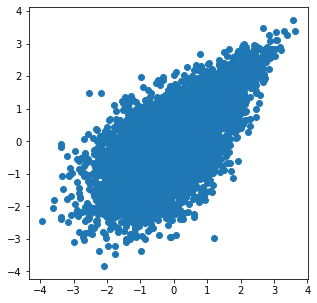

In [30]:
C = Gumbel(2, stats.norm, stats.norm)
s = C.sample(10000)
plt.figure(figsize=(5,5))
# plt.scatter(stats.norm.cdf(s[:,0]),stats.norm.cdf(s[:,1]))
plt.scatter(s[:,0], s[:,1])

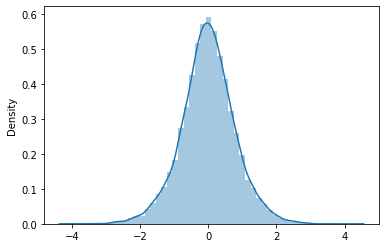

In [31]:
h=1
rh = s[:,0] - h*s[:,1]
sns.distplot(rh)

In [32]:
x_arr = np.linspace(min(rh), max(rh), 100)
result = []
for x in x_arr:
    result.append(C.f_RH(h, r_h=x))

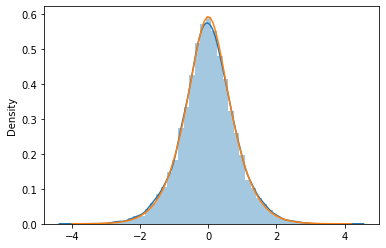

In [34]:
sns.distplot(rh)
plt.plot(x_arr, result)

In [61]:
C = t_Copula(0.9,4,stats.norm, stats.norm)
C.canonical_calibrate(u_arr, v_arr, 4)

Optimization terminated successfully.
         Current function value: -0.502971
         Iterations: 102
         Function evaluations: 197


array([0.79901785, 4.        ])

In [60]:
C.l_fn(0.776,2,u_arr, v_arr)

0.5155221857154079

In [29]:
C.theta

2.2621036767959595

In [250]:
class Plackett(Copula):
    def __init__(self, theta, Law_RS, Law_RF):
        self.theta  = theta    # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
    
    # from Joe's book, p. 141 (Family B2)
    def C(self, u, v):
        eta = self.theta - 1
        part1 = 1/(2*eta)
        part2 = 1+(eta*(u+v))
        part3 = (part2**2 - 4*eta*self.theta*u*v)**0.5
        return part1 * (part2-part3)
        
    def c(self, u,v):
        eta   = self.theta - 1
        part1 = ((1+eta*(u+v))**2 - 4*self.theta*eta*u*v)**(-3/2)
        part2 = self.theta * (1+eta*(u+v-2*u*v))
        return part1*part2
    
    def D1C_original(self, u,v):
        eta   = self.theta - 1
        part1 = 0.5*(eta*u+1 - (eta+2)*v)
        part2 = ((1+ eta*(u+v))**2 - 4*self.theta*eta*u*v)**0.5
        return 0.5-part1/part2
    
    def D1C(self, w, h, r_h):
        return self.D1C_original(w, self.g(w,h,r_h))
    
    def get_theta(self, u,v):
        C = self.C(u,v)
        part1 = C*(1-u-v+C)
        part2 = (u-C)*(v-C)
        return part1/part2
    
    # From Appendix C.7. of "Extreme in Nature"
    def Spearman_rho(self):
        part1 = (self.theta+1)/(self.theta-1)
        part2 = 2*self.theta*np.log(self.theta) / (self.theta-1)**2
        return part1 - part2

    def sample(self, size):
        samples = np.ones((size, 2))
        u = stats.uniform.rvs(size=size)
        t = stats.uniform.rvs(size=size)
        
        a = t*(1-t)
        b = self.theta+a*(self.theta-1)**2
        c = 2*a*(u*self.theta**2+1-u)+self.theta*(1-2*a)
        d = np.sqrt(self.theta*(self.theta+4*a*u*(1-u)*(1-self.theta)**2))
        v = (c-(1-2*t)*d)/(2*b)
        samples[:,0] = self.Law_RS.ppf(u)
        samples[:,1] = self.Law_RF.ppf(v)
        return samples
        
        
    def canonical_calibrate(self, u, v):
        fn_toopt = lambda theta: -self.l_fn(theta, u, v)
        result = scipy.optimize.fmin(fn_toopt, x0=self.theta, 
                             xtol=1e-10, 
                             maxiter=5000,
                             maxfun=400)
        self.theta = result[0]
        return result
    
    def l_fn(self, theta, u, v): # log dependency likelihood 
        eta   = theta - 1
        part1 = ((1+eta*(u+v))**2 - 4*theta*eta*u*v)**(-3/2)
        part2 = theta * (1+eta*(u+v-2*u*v))
        return np.nanmean(np.log(part1*part2))
 

In [251]:
C = Plackett(1000, stats.norm, stats.norm)

In [252]:
C.canonical_calibrate(u_arr, v_arr)

Optimization terminated successfully.
         Current function value: -0.482649
         Iterations: 49
         Function evaluations: 104


array([21.73784855])

In [253]:
s = C.sample(1000)

In [254]:
C.Spearman_rho()

0.785172502706402

In [255]:
stats.spearmanr(data.return_brr, data.return_btc)

SpearmanrResult(correlation=0.7337232561981398, pvalue=5.107300485721108e-110)

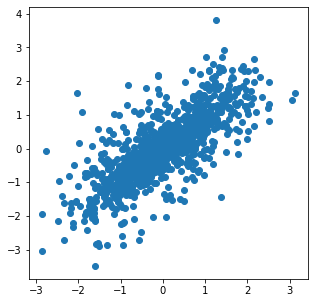

In [245]:
plt.figure(figsize=(5,5))
plt.scatter(s[:,0],s[:,1])

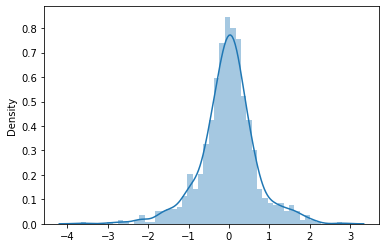

In [246]:
h=1
rh = s[:,0] - h*s[:,1] 
sns.distplot(rh)

In [229]:
x_arr = np.linspace(-4,4,100)
result=[]
for x in x_arr:
    result.append(C.f_RH(h,x))

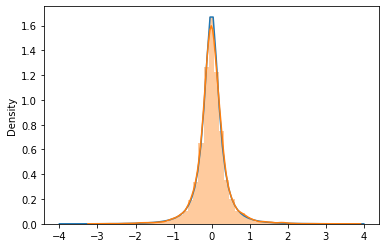

In [231]:
plt.plot(x_arr, result)
sns.distplot(rh)

In [261]:
theta = 10
def D1O_inv(u,v): #D1O's inverse
    part0 = -1/theta
    part1a = (1-np.exp(-theta))
    part1b = (1/v - 1)* np.exp(-theta*u)+1
    part1  = np.log(1- part1a/part1b)
    return part0*part1
    
def sample(size):
    u1 = stats.uniform.rvs(size=size)
    v  = stats.uniform.rvs(size=size)
    u2 = D1O_inv(u1,v)
    return u1, u2 
    
    
    
    

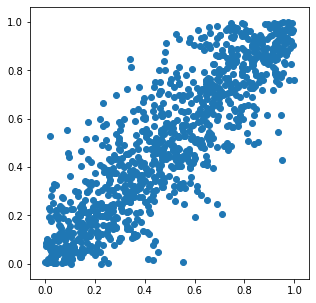

In [265]:
plt.figure(figsize=(5,5))
s = sample(1000)
plt.scatter(s[0], s[1])

In [270]:
C = Frank(10,stats.norm, stats.norm)

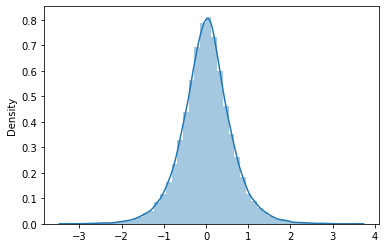

In [277]:
s = C.sample(30000)
rh = s[:,0] - h*s[:,1]
sns.distplot(rh)

In [278]:
x_arr = np.linspace(-4,4,100)
result=[]
for x in x_arr:
    result.append(C.f_RH(h,x))

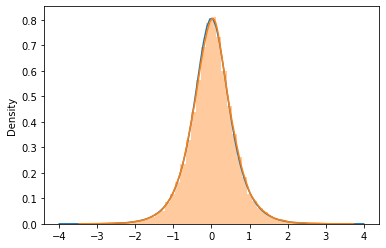

In [279]:
plt.plot(x_arr, result)
sns.distplot(rh)

In [425]:
# Stable distribution
size = 10000
U    = stats.uniform.rvs(size=size)*2*np.pi-np.pi
W    = stats.expon.rvs(size=size)

alpha = 1.7
beta  = 0
sigma = 1
mu    = 0

zi = -beta*np.tan(np.pi*alpha/2)

if alpha != 1:
    xi = 1/alpha * np.arctan(-zi)
else:
    xi = np.pi/2 
    
if alpha != 1:
    part1 = (1+zi**2)**(0.5/alpha)
    part2 = np.sin(alpha*(U+xi))/(np.cos(U)**(1/alpha))
    part3 = (np.cos(U-alpha*(U+xi))/W )**((1-alpha)/alpha)
    X = part1*part2*part3
else:
    part1  = ((np.pi/2)+beta*U)*np.tan(U)
    part2a = (np.pi/2)*W*np.cos(U)
    part2b = np.pi/2+beta*U
    part2  = beta*np.log(part2a/part2b)
    X =1/xi *(part1-part2)

if alpha == 1:
    Y = sigma*X+2/np.pi*beta*sigma*np.log(sigma)+mu
else:
    Y = sigma*X+mu

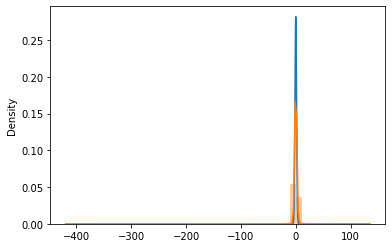

In [426]:
x_arr = np.linspace(-6,6,100)
plt.plot(x_arr,stats.norm(loc=0, scale=np.sqrt(2)).pdf(x_arr))
sns.distplot(Y)

In [442]:
def log_phi(t, alpha, beta, mu, sigma):
    part1 = -1*np.abs(sigma*t)**alpha
    part3 = 1j*mu*t

    if alpha != 1:
        part2 = 1-1j*beta*np.sign(t)*np.tan(np.pi*alpha/2)
    else:
        part2 = 1+1j*beta*np.sign(t)*2/np.pi*np.log(np.abs(t))
    return part1*part2+part3

def pdf(x):
    fn = lambda t: np.exp(-1j*t*x)*np.exp(log_phi(t,2,0,0,1))
    return scipy.integrate.quad(fn,-np.inf, np.inf)[0]/(2*np.pi)

In [445]:
pdf(10)

3.917712430559688e-12

In [446]:
stats.norm(scale=np.sqrt(2)).pdf(10)

3.917716632754348e-12

In [424]:
np.tan(U[np.isnan(Y)])

array([ 0.40925333, -0.23888742, -0.04570466, ...,  3.69815208,
       -0.13499089, -0.97881174])

In [380]:
X = stats.uniform.rvs(size=1000)
CA = np.tan(np.pi*(X-0.5))

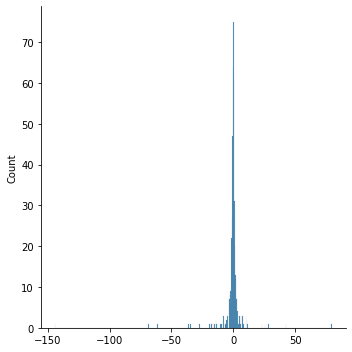

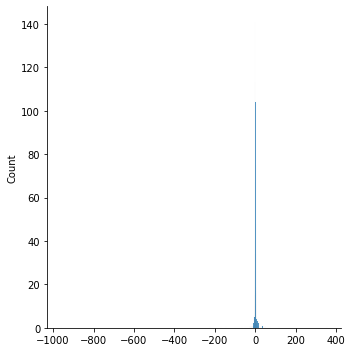

In [388]:
sns.displot(Y)
sns.displot(CA)

In [2]:
D = stable(2,0,0,1)

In [3]:
D.pdf(0.1) - stats.norm(scale=np.sqrt(2)).pdf(0.1)

0.0

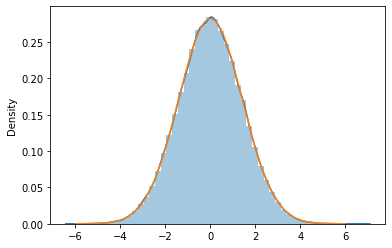

In [16]:
sns.distplot(D.rvs(100000))
x_arr = np.linspace(-6,6,1000)
plt.plot(x_arr, stats.norm(scale=np.sqrt(2)).pdf(x_arr))

In [15]:
# Algo 5.48 of McNeil p.224
size=10000
# sigma = gamma, delta = mu
theta = 20
gamma = np.cos(np.pi/(2*theta))**theta

# samples of stable contain NaNs; Draw more samples and discard NaNs until len(V) = size
con = True # continue or not
m   = 1
while con:
    V = stable(1/theta, 1, 0, gamma).rvs(size*m)
    V = V[~np.isnan(V)][:size]
    if len(V) != size:
        con = True
        m  +=1
    else:
        con = False
        
G_hat = lambda t: np.exp(-t**(1/theta))

X1 = stats.uniform.rvs(size=size)
X2 = stats.uniform.rvs(size=size)

U1 = G_hat(-np.log(X1)/V)
U2 = G_hat(-np.log(X2)/V)

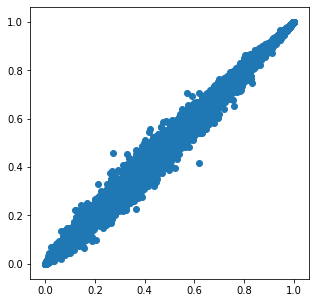

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(U1,U2)